In [12]:
import csv
import math
from typing import Dict

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot 
import optuna

from sklearn import *

In [13]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

target_labels = ["Оператор", "Есть ли Интернет", "Состав ДХ"]

y = train_data.loc[:, target_labels]
X = train_data.drop(target_labels, axis=1)

index_of_test_data_beginning = len(X.index)
X = pd.concat([X, test_data], ignore_index=True)

X

,id,hhid,Общее телесмотрение,Телесмотрение ночью,Телесмотрение утром,Телесмотрение в рабочее время,Телесмотрение в вечернее время,Телесмотрение в прайм тайм,Общее телесмотрение Пн-Пт,Телесмотрение ночью Пн-Пт,...,Просмотр жанра спорт в праздники,Просмотр жанра музыка в рабочее время,Просмотр жанра музыка в праздники,Просмотр жанра образования в рабочее время,Просмотр жанра образование в праздники,Размер ДХ,Тип ресивера,ФО,Тип нас.пункта,Почтовый индекс
0,0,3348,647,437,15.0,12,120,63,195.0,0,...,0,0,0,0,1,4.0,Ресивер с поддержкой HDTV,Северо-Западный федеральный округ,Город с численностью от 45 тыс. до 400 тыс.,182180
1,1,4182,2657,538,363.0,1582,174,0,415.0,133,...,0,0,0,1,109,4.0,Ресивер с поддержкой HEVC,Уральский федеральный округ,Город с численностью менее 45 тыс.,457024
2,2,1233,1385,0,49.0,1134,202,0,729.0,0,...,16,0,0,0,0,2.0,Ресивер с поддержкой HDTV,Южный федеральный округ,Город более 400 тыс.,350901
3,3,4813,2861,607,857.0,1374,23,0,1249.0,294,...,0,0,0,11,11,2.0,Ресивер с поддержкой HEVC,Приволжский федеральный округ,Сельский населенный пункт,452774
4,4,1782,478,174,44.0,53,79,128,260.0,0,...,0,0,0,0,0,4.0,Ресивер с поддержкой HDTV,Северо-Западный федеральный округ,Сельский населенный пункт,168068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4050,4050,565,3440,431,300.0,1750,463,496,1604.0,118,...,0,0,0,0,1,3.0,Ресивер с поддержкой HDTV,Центральный федеральный округ,Город более 400 тыс.,153008
4051,4051,4747,914,7,20.0,865,22,0,400.0,0,...,0,0,0,0,0,2.0,Ресивер с поддержкой HEVC,Центральный федеральный округ,Сельский населенный пункт,309740
4052,4052,4400,1331,1,0.0,526,474,330,754.0,1,...,0,0,0,0,0,4.0,Ресивер с поддержкой HDTV,Южный федеральный округ,Город более 400 тыс.,350088
4053,4053,3089,2748,788,440.0,1260,189,71,491.0,164,...,9,0,0,4,178,2.0,Ресивер с поддержкой HEVC,Сибирский федеральный округ,Город более 400 тыс.,656012


In [14]:
X.drop(["id", "hhid"], axis=1, inplace=True)

In [15]:
X.isna().sum()

Общее телесмотрение                            0
Телесмотрение ночью                            0
Телесмотрение утром                           25
Телесмотрение в рабочее время                  0
Телесмотрение в вечернее время                 0
Телесмотрение в прайм тайм                     0
Общее телесмотрение Пн-Пт                     25
Телесмотрение ночью Пн-Пт                      0
Телесмотрение утром Пн-Пт                      0
Телесмотрение в рабочее время Пн-Пт            0
Телесмотрение в вечернее время Пн-Пт           0
Телесмотрение в прайм тайм Пн-Пт               0
Общее телесмотрение в выходные                 0
Телесмотрение ночью в выходные                 0
Телесмотрение утром в выходные                 0
Телесмотрение в рабочее время в выходные       0
Телесмотрение вечером в выходные               0
Телесмотрение в прайм тайм в выходные          0
Просмотр жанра кино в рабочее время            0
Просмотр жанра кино в праздники                0
Просмотр жанра прикл

In [16]:
col_names_for_tv_viewing = ["Телесмотрение утром", "Телесмотрение ночью", "Телесмотрение в рабочее время", "Телесмотрение в вечернее время", "Телесмотрение в прайм тайм", "Общее телесмотрение"]

indexes_of_rows_with_missed_values_for_morning_tv_viewing = X[col_names_for_tv_viewing[0]].isnull().where(lambda x: x).dropna().index

tv_viewing_per_part_of_day_and_in_total = X.loc[indexes_of_rows_with_missed_values_for_morning_tv_viewing, col_names_for_tv_viewing[1:]]

tv_viewing_in_total = tv_viewing_per_part_of_day_and_in_total[col_names_for_tv_viewing[-1]]
tv_viewing_per_part_of_day_and_in_total.drop(col_names_for_tv_viewing[-1], axis=1, inplace=True)

morning_tv_viewing_data = []
for index, row in tv_viewing_per_part_of_day_and_in_total.iterrows():
    morning_tv_viewing = tv_viewing_in_total[index] - sum(row)
    morning_tv_viewing_data.append(morning_tv_viewing)
morning_tv_viewings = pd.Series(data=morning_tv_viewing_data, index=tv_viewing_per_part_of_day_and_in_total.index)

X.loc[morning_tv_viewings.index, col_names_for_tv_viewing[0]] = morning_tv_viewings

X.loc[morning_tv_viewings.index, :]

,Общее телесмотрение,Телесмотрение ночью,Телесмотрение утром,Телесмотрение в рабочее время,Телесмотрение в вечернее время,Телесмотрение в прайм тайм,Общее телесмотрение Пн-Пт,Телесмотрение ночью Пн-Пт,Телесмотрение утром Пн-Пт,Телесмотрение в рабочее время Пн-Пт,...,Просмотр жанра спорт в праздники,Просмотр жанра музыка в рабочее время,Просмотр жанра музыка в праздники,Просмотр жанра образования в рабочее время,Просмотр жанра образование в праздники,Размер ДХ,Тип ресивера,ФО,Тип нас.пункта,Почтовый индекс
987,578,123,42.0,336,77,0,429.0,0,17,335,...,0,1,0,0,0,3.0,Ресивер с поддержкой HEVC,Приволжский федеральный округ,Город с численностью от 45 тыс. до 400 тыс.,617060
988,504,0,131.0,225,121,27,308.0,0,0,160,...,24,0,0,0,0,2.0,Ресивер с поддержкой HEVC,Приволжский федеральный округ,Сельский населенный пункт,452020
989,409,110,0.0,282,17,0,408.0,109,0,282,...,0,0,0,3,0,2.0,Ресивер с поддержкой HDTV,Уральский федеральный округ,Город с численностью от 45 тыс. до 400 тыс.,622051
990,1517,0,146.0,1202,156,13,617.0,0,118,499,...,0,105,26,0,0,4.0,Ресивер с поддержкой HEVC,Южный федеральный округ,Сельский населенный пункт,353417
991,49,0,0.0,49,0,0,0.0,0,0,0,...,0,0,0,0,0,2.0,Ресивер с поддержкой HEVC,Южный федеральный округ,Сельский населенный пункт,353366
992,1047,77,160.0,507,123,180,76.0,76,0,0,...,0,0,0,0,0,3.0,Ресивер с поддержкой HEVC,Центральный федеральный округ,Город с численностью от 45 тыс. до 400 тыс.,143002
993,227,0,16.0,211,0,0,211.0,0,0,211,...,0,0,0,0,0,2.0,Ресивер с поддержкой HEVC,Центральный федеральный округ,Сельский населенный пункт,396370
994,1690,3,123.0,905,425,234,704.0,2,53,300,...,10,0,0,0,0,1.0,Ресивер с поддержкой HEVC,Северо-Западный федеральный округ,Сельский населенный пункт,180560
995,411,0,134.0,248,29,0,159.0,0,129,30,...,0,0,0,0,0,4.0,Ресивер с поддержкой HEVC,Северо-Западный федеральный округ,Город с численностью менее 45 тыс.,169420
996,2164,431,265.0,1083,199,186,819.0,111,155,218,...,0,0,0,1,0,2.0,Ресивер с поддержкой HEVC,Южный федеральный округ,Сельский населенный пункт,347660


In [17]:
col_names_for_tv_viewing_in_work_days = ["Общее телесмотрение Пн-Пт", "Телесмотрение утром Пн-Пт", "Телесмотрение ночью Пн-Пт", "Телесмотрение в рабочее время Пн-Пт", "Телесмотрение в вечернее время Пн-Пт", "Телесмотрение в прайм тайм Пн-Пт"]

indexes_of_rows_with_missed_values_for_tv_viewing_in_total = X[col_names_for_tv_viewing_in_work_days[0]].isnull().where(lambda x: x).dropna().index

tv_viewing_per_part_of_day = X.loc[indexes_of_rows_with_missed_values_for_tv_viewing_in_total, col_names_for_tv_viewing_in_work_days[1:]]

tv_viewing_in_total_data = []
for index, row in tv_viewing_per_part_of_day.iterrows():
    tv_viewing_in_total = sum(row)
    tv_viewing_in_total_data.append(tv_viewing_in_total)
tv_viewings_in_total = pd.Series(data=tv_viewing_in_total_data, index=tv_viewing_per_part_of_day.index)

X.loc[tv_viewings_in_total.index, col_names_for_tv_viewing_in_work_days[0]] = tv_viewings_in_total

X.loc[tv_viewings_in_total.index, :]

,Общее телесмотрение,Телесмотрение ночью,Телесмотрение утром,Телесмотрение в рабочее время,Телесмотрение в вечернее время,Телесмотрение в прайм тайм,Общее телесмотрение Пн-Пт,Телесмотрение ночью Пн-Пт,Телесмотрение утром Пн-Пт,Телесмотрение в рабочее время Пн-Пт,...,Просмотр жанра спорт в праздники,Просмотр жанра музыка в рабочее время,Просмотр жанра музыка в праздники,Просмотр жанра образования в рабочее время,Просмотр жанра образование в праздники,Размер ДХ,Тип ресивера,ФО,Тип нас.пункта,Почтовый индекс
1000,1935,151,207.0,1117,221,239,304.0,4,0,79,...,0,0,0,0,0,2.0,Ресивер с поддержкой HEVC,Южный федеральный округ,Сельский населенный пункт,353423
1001,264,106,0.0,158,0,0,40.0,16,0,24,...,0,0,0,0,0,3.0,Ресивер с поддержкой HDTV,Уральский федеральный округ,Сельский населенный пункт,456402
1002,1265,18,441.0,712,94,0,0.0,0,0,0,...,0,0,0,0,0,6.0,Ресивер с поддержкой HDTV,Приволжский федеральный округ,Город с численностью менее 45 тыс.,606912
1003,3156,113,550.0,1888,267,338,1473.0,60,185,881,...,0,0,0,0,22,3.0,Ресивер с поддержкой HEVC,Южный федеральный округ,Сельский населенный пункт,347512
1004,1575,0,0.0,709,484,382,806.0,0,0,372,...,0,0,0,0,0,3.0,Ресивер с поддержкой HEVC,Приволжский федеральный округ,Сельский населенный пункт,462800
1005,1855,440,480.0,935,0,0,272.0,76,51,145,...,0,0,0,0,0,4.0,Ресивер с поддержкой HDTV,Приволжский федеральный округ,Город с численностью менее 45 тыс.,423520
1006,1874,0,233.0,1470,149,22,1080.0,0,233,847,...,0,0,0,0,0,2.0,Ресивер с поддержкой HEVC,Центральный федеральный округ,Город с численностью менее 45 тыс.,171900
1007,1157,0,127.0,915,115,0,506.0,0,127,379,...,0,0,0,0,0,5.0,Ресивер с поддержкой HEVC,Южный федеральный округ,Сельский населенный пункт,353993
1008,701,9,183.0,508,1,0,623.0,9,183,431,...,0,0,0,0,0,6.0,Ресивер с поддержкой HEVC,Северо-Кавказский федеральный округ,Сельский населенный пункт,366501
1009,686,175,194.0,317,0,0,660.0,175,186,299,...,0,0,0,0,0,2.0,Ресивер с поддержкой HEVC,Центральный федеральный округ,Сельский населенный пункт,152861


In [18]:
family = y["Состав ДХ"].apply(lambda x: x.split(" и "))
y.drop("Состав ДХ", axis=1, inplace=True)

elder_generation  = family.transform(lambda x: x[0])
children = family.transform(lambda x: x[1])

y["Члены семьи в возрасте от 55 лет"] = elder_generation
y["Члены семьи до 18 лет"] = children

In [19]:
encoder_per_label = {
    "Оператор": preprocessing.LabelEncoder(),
    "Есть ли Интернет": preprocessing.LabelEncoder(),
    "Члены семьи в возрасте от 55 лет": preprocessing.LabelEncoder(),
    "Члены семьи до 18 лет": preprocessing.LabelEncoder()
}

for label in encoder_per_label.keys():
    y[label] = encoder_per_label[label].fit_transform(y[label])

predictor_col_names = list(encoder_per_label.keys())

In [20]:
categorical_encoder = preprocessing.LabelEncoder()

X.loc[:, ["Тип ресивера", "Тип нас.пункта"]] = X.loc[:, ["Тип ресивера", "Тип нас.пункта"]].apply(categorical_encoder.fit_transform)
X["Тип нас.пункта"].where(lambda x: x != 4, other=np.nan, inplace=True)
X["Тип ресивера"] = X["Тип ресивера"].astype(int)

# X.loc[:, ["Тип ресивера", "ФО", "Тип нас.пункта"]]
X.loc[:, ["Тип ресивера", "Тип нас.пункта"]]

,Тип ресивера,Тип нас.пункта
0,0,2
1,1,1
2,0,0
3,1,3
4,0,3
...,...,...
4050,0,0
4051,1,3
4052,0,0
4053,1,0


In [21]:
standard_scaler = preprocessing.StandardScaler()
tv_viewing_data = X.drop(["Размер ДХ", "Тип ресивера", "Тип нас.пункта", "ФО", "Почтовый индекс"], axis=1)

X.loc[:, tv_viewing_data.columns] = standard_scaler.fit_transform(tv_viewing_data)

In [22]:
scaler = preprocessing.MinMaxScaler()
post_index = X["Почтовый индекс"].to_numpy().reshape(-1, 1)

X["Почтовый индекс"] = scaler.fit_transform(post_index)

X["Почтовый индекс"]

0       0.029493
1       0.073988
2       0.056808
3       0.073300
4       0.027209
          ...   
4050    0.024771
4051    0.050144
4052    0.056676
4053    0.106202
4054    0.027834
Name: Почтовый индекс, Length: 4055, dtype: float64

In [23]:
federal_district_one_hot_encoded = pd.get_dummies(X.loc[:, ["ФО"]]).astype(int)
X = pd.concat([X, federal_district_one_hot_encoded], axis=1)
X.drop(["ФО"], axis=1, inplace=True)

In [24]:
# n_neighbors = sqrt(number_of_samples)/2
imputer = impute.KNNImputer(n_neighbors=28)

cols_for_household_size_imputation = [*tv_viewing_data.columns, "Размер ДХ"]
data_for_household_size_imputation = X.loc[:, cols_for_household_size_imputation]

indexes_of_rows_with_missing_values_for_household_size= data_for_household_size_imputation.loc[:, "Размер ДХ"].isna().where(lambda x: x).dropna().index
rows_with_missing_values_for_household_size = data_for_household_size_imputation.loc[indexes_of_rows_with_missing_values_for_household_size, :]
#
rows_without_missing_values_for_household_size = data_for_household_size_imputation.loc[X["Размер ДХ"].notna().where(lambda x: x).dropna().index, :]

imputer.fit(rows_without_missing_values_for_household_size)
# 
imputed_data = imputer.transform(rows_with_missing_values_for_household_size)

index_of_household_column = data_for_household_size_imputation.columns.get_loc("Размер ДХ")
for imputed_row  in imputed_data:
    imputed_row[index_of_household_column] = round(imputed_row[index_of_household_column])

X.loc[indexes_of_rows_with_missing_values_for_household_size, cols_for_household_size_imputation] = imputed_data

X.loc[indexes_of_rows_with_missing_values_for_household_size]

# kind_of_inhabited_locality_formatted_for_decoding = X.loc[:, ["Тип нас.пункта"]].to_numpy().reshape(1, -1)[0].astype(int)
# X["Тип нас.пункта"] = categorical_encoder.inverse_transform(kind_of_inhabited_locality_formatted_for_decoding)

,Общее телесмотрение,Телесмотрение ночью,Телесмотрение утром,Телесмотрение в рабочее время,Телесмотрение в вечернее время,Телесмотрение в прайм тайм,Общее телесмотрение Пн-Пт,Телесмотрение ночью Пн-Пт,Телесмотрение утром Пн-Пт,Телесмотрение в рабочее время Пн-Пт,...,Тип ресивера,Тип нас.пункта,Почтовый индекс,ФО_Приволжский федеральный округ,ФО_Северо-Западный федеральный округ,ФО_Северо-Кавказский федеральный округ,ФО_Сибирский федеральный округ,ФО_Уральский федеральный округ,ФО_Центральный федеральный округ,ФО_Южный федеральный округ
2004,1.032353,-0.527804,1.444114,0.968233,1.974052,0.069158,0.794548,-0.559718,1.688401,0.471173,...,0,2,0.022895,0,0,0,0,0,1,0
2005,2.101516,2.947383,1.933736,1.676248,1.304999,-0.419855,1.558508,4.523572,1.369706,0.477206,...,0,3,0.064648,0,0,0,0,0,1,0
2006,-0.879289,-0.596790,-0.098657,-1.164850,-0.121472,-0.206695,-0.696197,-0.475465,0.832477,-0.988701,...,1,1,0.106638,0,0,0,1,0,0,0
2007,-0.088573,-0.644218,-0.380420,0.291853,0.149936,-0.532704,0.002706,-0.559718,-0.797422,0.447043,...,1,3,0.073178,1,0,0,0,0,0,0
2008,-0.695443,-0.644218,-0.934709,-0.791259,0.187807,0.426514,-0.746384,-0.559718,-0.815633,-0.696123,...,1,3,0.057855,0,0,1,0,0,0,0
2009,0.365688,-0.066458,0.224678,0.742271,-0.197214,-0.532704,0.538036,-0.391211,0.022080,1.219208,...,1,0,0.063143,0,0,0,0,0,1,0
2010,-1.082770,-0.644218,-0.934709,-1.155812,-0.197214,-0.394777,-0.846758,-0.559718,-0.815633,-1.030929,...,0,3,0.066459,1,0,0,0,0,0,0
2011,0.705714,2.192845,1.753592,0.114096,-0.556987,-0.532704,1.489733,3.746568,1.715718,0.772800,...,1,3,0.073310,1,0,0,0,0,0,0
2012,1.159974,0.994207,-0.551326,1.254452,1.614278,0.627134,0.285241,1.228327,-0.496938,-0.056674,...,1,3,0.057855,0,0,1,0,0,0,0
2013,0.047973,-0.626972,-0.860804,0.569033,-0.077289,0.125583,-0.365333,-0.522272,-0.806527,0.106205,...,1,3,0.073191,1,0,0,0,0,0,0


In [25]:
cols_for_type_of_inhabited_locality_imputation = [*federal_district_one_hot_encoded.columns, "Почтовый индекс", "Тип нас.пункта"]
data_for_type_of_inhabited_locality_imputation = X.loc[:, cols_for_type_of_inhabited_locality_imputation]

indexes_of_rows_with_missing_values_for_type_of_inhabited_locality = data_for_type_of_inhabited_locality_imputation.loc[:, "Тип нас.пункта"].isna().where(lambda x: x).dropna().index

rows_with_missing_values_for_type_of_inhabited_locality = data_for_type_of_inhabited_locality_imputation.loc[indexes_of_rows_with_missing_values_for_type_of_inhabited_locality, :]
#
rows_without_missing_values_for_type_of_inhabited_locality = data_for_type_of_inhabited_locality_imputation.loc[X["Тип нас.пункта"].notna().where(lambda x: x).dropna().index, :]

imputer.fit(rows_without_missing_values_for_type_of_inhabited_locality)
# 
imputed_data = imputer.transform(rows_with_missing_values_for_type_of_inhabited_locality)

index_of_type_of_inhabited_locality_column = data_for_type_of_inhabited_locality_imputation.columns.get_loc("Тип нас.пункта")
for imputed_row  in imputed_data:
    imputed_row[index_of_type_of_inhabited_locality_column] = round(imputed_row[index_of_type_of_inhabited_locality_column])

X.loc[indexes_of_rows_with_missing_values_for_type_of_inhabited_locality, cols_for_type_of_inhabited_locality_imputation] = imputed_data

X.loc[indexes_of_rows_with_missing_values_for_type_of_inhabited_locality]

# kind_of_inhabited_locality_formatted_for_decoding = X.loc[:, ["Тип нас.пункта"]].to_numpy().reshape(1, -1)[0].astype(int)
# X["Тип нас.пункта"] = categorical_encoder.inverse_transform(kind_of_inhabited_locality_formatted_for_decoding)

,Общее телесмотрение,Телесмотрение ночью,Телесмотрение утром,Телесмотрение в рабочее время,Телесмотрение в вечернее время,Телесмотрение в прайм тайм,Общее телесмотрение Пн-Пт,Телесмотрение ночью Пн-Пт,Телесмотрение утром Пн-Пт,Телесмотрение в рабочее время Пн-Пт,...,Тип ресивера,Тип нас.пункта,Почтовый индекс,ФО_Приволжский федеральный округ,ФО_Северо-Западный федеральный округ,ФО_Северо-Кавказский федеральный округ,ФО_Сибирский федеральный округ,ФО_Уральский федеральный округ,ФО_Центральный федеральный округ,ФО_Южный федеральный округ
200,1.367916,0.442316,1.878307,0.936599,1.437547,1.091069,0.225760,0.704083,2.444164,-0.406561,...,1,3.0,0.059581,0,0,1,0,0,0,0
201,-0.761485,-0.644218,-0.814613,-0.467380,-0.834707,-0.532704,-1.075389,-0.559718,-0.815633,-1.030929,...,1,3.0,0.074798,1,0,0,0,0,0,0
202,-0.002005,-0.359650,-0.214134,0.519322,-0.834707,-0.532704,0.723914,0.039418,0.604837,1.225240,...,1,1.0,0.024684,0,0,0,0,0,1,0
203,-0.323289,1.429683,-0.089419,-0.688823,-0.834707,-0.532704,-0.547494,0.573023,-0.815633,-0.539277,...,0,2.0,0.107228,0,0,0,1,0,0,0
204,-0.782012,-0.644218,-0.925471,-0.465874,-0.834707,-0.532704,-0.579094,-0.559718,-0.797422,-0.231617,...,1,2.0,0.023151,0,0,0,0,0,1,0
205,1.836456,1.214101,0.451013,1.411119,2.087664,2.576916,1.906101,0.544938,1.633767,2.142186,...,0,1.0,0.024771,0,0,0,0,0,1,0
206,-1.187187,-0.644218,-0.934709,-1.146773,-0.834707,-0.532704,-1.064236,-0.559718,-0.815633,-1.012831,...,0,3.0,0.101404,0,0,0,0,1,0,0
207,0.366580,-0.501934,0.820539,0.853746,-0.834707,-0.532704,1.010167,-0.381850,0.841582,1.747055,...,1,3.0,0.057207,0,0,0,0,0,0,1
208,-0.468759,-0.644218,-0.371182,-0.117892,-0.834707,-0.532704,0.513872,-0.559718,0.286142,1.183013,...,1,3.0,0.063547,0,0,0,0,0,1,0
209,0.021199,-0.644218,-0.348087,0.456052,0.194119,-0.532704,0.307547,-0.559718,0.340775,0.609921,...,1,1.0,0.024745,0,0,0,0,0,1,0


In [26]:
# kind_of_inhabited_locality = [
#     [
#         "Сельский населенный пункт",
#         "Город с численностью менее 45 тыс.",
#         "Город с численностью от 45 тыс. до 400 тыс.",
#         "Город более 400 тыс."
#     ]
# ]
# print(kind_of_inhabited_locality.reshape(-1 , 1))

# ordinal_encoder = preprocessing.OneHotEncoder(
#     # categories=kind_of_inhabited_locality
# )
kind_of_inhabited_locality_one_hot_encoded = pd.get_dummies(X.loc[:, ["Тип нас.пункта"]]).astype(int)
print(kind_of_inhabited_locality_one_hot_encoded)
X = pd.concat([X, kind_of_inhabited_locality_one_hot_encoded], axis=1)
X.drop(["Тип нас.пункта"], axis=1, inplace=True)

# print(ordinal_encoder.fit_transform().toarray())

# print(ordinal_encoder.categories_) 

      Тип нас.пункта_0  Тип нас.пункта_1  Тип нас.пункта_2  Тип нас.пункта_3
0                    0                 0                 1                 0
1                    0                 1                 0                 0
2                    1                 0                 0                 0
3                    0                 0                 0                 1
4                    0                 0                 0                 1
...                ...               ...               ...               ...
4050                 1                 0                 0                 0
4051                 0                 0                 0                 1
4052                 1                 0                 0                 0
4053                 1                 0                 0                 0
4054                 0                 0                 0                 1

[4055 rows x 4 columns]


In [27]:
X.drop([*federal_district_one_hot_encoded.columns, "Почтовый индекс"], axis=1, inplace=True)

<Axes: >

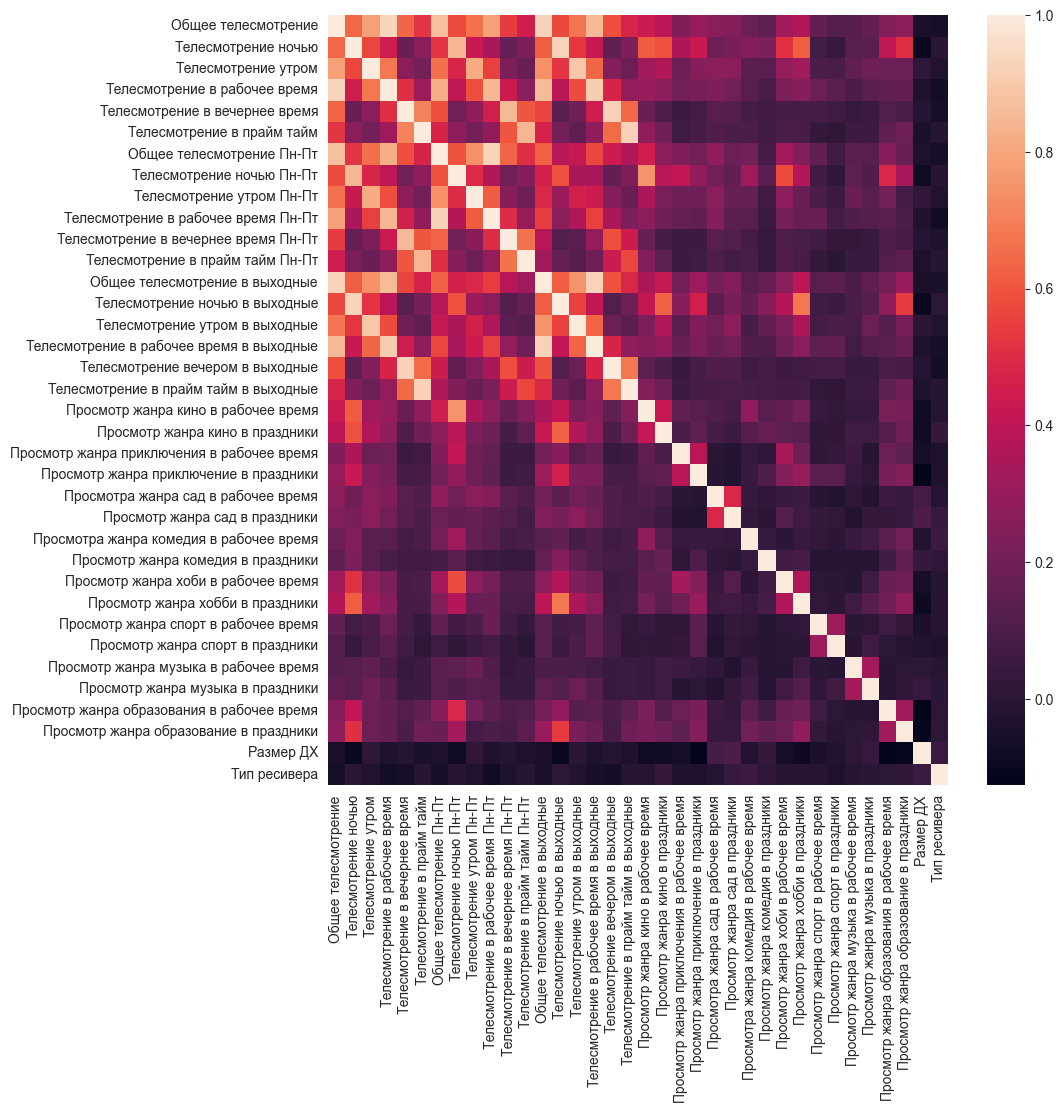

In [28]:
pyplot.subplots(figsize=(10, 10))

sns.heatmap(X.drop(kind_of_inhabited_locality_one_hot_encoded, axis=1).corr(), xticklabels=1, yticklabels=1)

Общее телесмотрение                           0.074005
Телесмотрение ночью                           0.010242
Телесмотрение утром                           0.040870
Телесмотрение в рабочее время                 0.077599
Телесмотрение в вечернее время                0.063857
Телесмотрение в прайм тайм                    0.061823
Общее телесмотрение Пн-Пт                     0.087728
Телесмотрение ночью Пн-Пт                     0.043484
Телесмотрение утром Пн-Пт                     0.064629
Телесмотрение в рабочее время Пн-Пт           0.085158
Телесмотрение в вечернее время Пн-Пт          0.042044
Телесмотрение в прайм тайм Пн-Пт              0.053291
Общее телесмотрение в выходные                0.050377
Телесмотрение ночью в выходные               -0.014619
Телесмотрение утром в выходные                0.011613
Телесмотрение в рабочее время в выходные      0.054887
Телесмотрение вечером в выходные              0.068041
Телесмотрение в прайм тайм в выходные         0.056327
Просмотр ж

<Axes: >

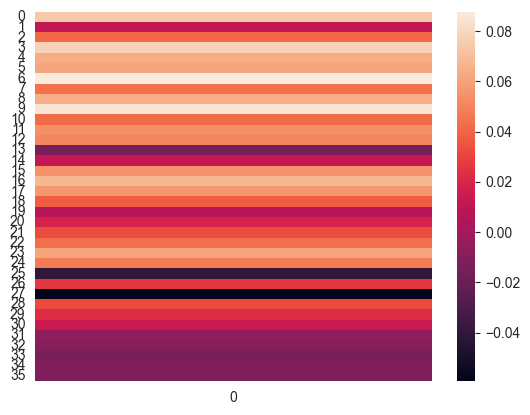

In [29]:
# print(y.loc[:, "Оператор"].shape)
# print(X.drop(kind_of_inhabited_locality_one_hot_encoded, axis=1).shape)
print(X.drop(kind_of_inhabited_locality_one_hot_encoded, axis=1).corrwith(y["Оператор"]))
sns.heatmap(np.asarray(X.drop(kind_of_inhabited_locality_one_hot_encoded, axis=1).corrwith(y["Оператор"])).reshape(-1, 1), xticklabels=1, yticklabels=1)

In [30]:
X_final_test = X.iloc[index_of_test_data_beginning:]
X = X.iloc[:index_of_test_data_beginning]

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X,
    y,
    test_size=.15,
    random_state=42
)

In [31]:
def opt_objective(trial):
    # hyperparameter_max_depth_range = trial.suggest_int(name="max_depth", low=2, high=64, log=True)
    # hyperparameter_n_estimators_range = trial.suggest_int(name="n_estimators", low=30, high=500, log=True)
    # hyperparameter_min_samples_leaf_range = trial.suggest_int(name="min_samples_leaf", low=1, high=3)
    # hyperparameter_criterion_range = trial.suggest_categorical(name="criterion", choices=["gini", "entropy"])
    # hyperparameter_min_samples_split_range = trial.suggest_int(name="min_samples_split", low=2, high=6, log=True)
    # hyperparameter_max_features_range = trial.suggest_categorical(name="max_features", choices=["sqrt", "log2", None])
    # 
    # classifier_tuned_with_random_hyperparameter_values = ensemble.ExtraTreesClassifier(
    #     n_estimators=hyperparameter_n_estimators_range,
    #     criterion=hyperparameter_criterion_range,
    #     max_depth=hyperparameter_max_depth_range,
    #     min_samples_split=hyperparameter_min_samples_split_range,
    #     min_samples_leaf=hyperparameter_min_samples_leaf_range,
    #     max_features=hyperparameter_max_features_range,
    #     warm_start=True,
    #     random_state=42,
    # )
    hidden_layer_sizes_range = trial.suggest_int(name="hidden_layer_sizes", low=50, high=500, log=True)
    solver_range = trial.suggest_categorical(name="solver", choices=["lbfgs", "adam", "sgd"])
    max_iter_range = trial.suggest_int(name="max_iter", low=100, high=500, log=True)
    learning_rate_range = trial.suggest_categorical(name="learning_rate", choices=["constant", "invscaling", "adaptive"])

    classifier_tuned_with_random_hyperparameter_values = neural_network.MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes_range,
        solver=solver_range,
        max_iter=max_iter_range,
        learning_rate=learning_rate_range,
        warm_start=True
    )
    
    multilabel_classifier_ =multioutput.ClassifierChain(classifier_tuned_with_random_hyperparameter_values)

    multilabel_classifier_.fit(X_train, y_train)
    # classifier_chain.score
    predictions_col_wise_ = multilabel_classifier_.predict(X_test).T
    
    mean_metric_scores = {"f1": 0, "cohen_kappa": 0, "accuracy": 0}
    for i, (predictions, label) in enumerate(zip(predictions_col_wise_, y_test.columns)):
        actual_values = y_test[label]
    
        accuracy_score = metrics.accuracy_score(actual_values, predictions)
        mean_metric_scores["accuracy"] += accuracy_score
    
        f1_score = metrics.f1_score(actual_values, predictions)
        mean_metric_scores["f1"] += f1_score
    
        cohen_kappa_score = metrics.cohen_kappa_score(actual_values, predictions)
        mean_metric_scores["cohen_kappa"] += cohen_kappa_score
    for metric_name in mean_metric_scores.keys():
        mean_metric_scores.update({metric_name: mean_metric_scores.get(metric_name) / 4})
    return tuple(mean_metric_scores.values())

# study = optuna.create_study(directions=["maximize", "maximize", "maximize"])
# 
# study.optimize(opt_objective, n_trials=100)
# 
# trial_with_highest_mean_metric_scores = max(study.best_trials, key=lambda x: x.values[1])
# print(trial_with_highest_mean_metric_scores.params)
# print(trial_with_highest_mean_metric_scores.values)

[I 2024-02-21 11:57:51,682] A new study created in memory with name: no-name-aa32f4ec-2001-4738-ac7b-3a36746d6759
/home/max/coding/tech_tasks/saber/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/max/coding/tech_tasks/saber/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/max/coding/tech_tasks/saber/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
[I 2024-02-21 11:58:18,151] Trial 0 finished with values: [0.8542365517342058, 0.6255880619511995, 0.8542094455852156] and parameters: {'hidden_layer_sizes': 499, 'solver': 'adam', 'max_iter': 377, 'learning_rate': 'adaptive'}. 
/home/max/coding/t

In [32]:
# # X_ = X.drop(['Просмотр жанра кино в рабочее время',
# #             'Просмотр жанра кино в праздники',
# #             'Просмотр жанра приключения в рабочее время',
# #             'Просмотр жанра приключение в праздники',
# #             'Просмотра жанра сад в рабочее время', 'Просмотр жанра сад в праздники',
# #             'Просмотра жанра комедия в рабочее время',
# #             'Просмотр жанра комедия в праздники',
# #             'Просмотр жанра хоби в рабочее время',
# #             'Просмотр жанра хобби в праздники',
# #             'Просмотр жанра спорт в рабочее время',
# #             'Просмотр жанра спорт в праздники',
# #             'Просмотр жанра музыка в рабочее время',
# #             'Просмотр жанра музыка в праздники',
# #             'Просмотр жанра образования в рабочее время',
# #             'Просмотр жанра образование в праздники'], axis=1)
# 
# # X_final_test = X.iloc[index_of_test_data_beginning:]
# X__ = X.iloc[:index_of_test_data_beginning]
# 
# X_train_, X_test_, y_train_, y_test_ = model_selection.train_test_split(
#     X__,
#     y,
#     test_size=.15,
#     random_state=42
# )
# 
best_found_model = ensemble.ExtraTreesClassifier(
    max_depth=64,
    n_estimators=59,
    min_samples_leaf=1,
    criterion='gini',
    min_samples_split=2,
    max_features='sqrt',
    warm_start=True,
    random_state=42
)
multilabel_classifier =multioutput.ClassifierChain(
    best_found_model,
    random_state=42
)
# 
multilabel_classifier.fit(X_train, y_train)

multilabel_predictions = multilabel_classifier.predict(X_test).T

scores_per_metric = pd.DataFrame(columns=predictor_col_names, index=["accuracy","f1", "cohen_kappa"])
for i, (predictions, predictor_col_name) in enumerate(zip(multilabel_predictions, predictor_col_names)):
    actual_values = y_test[predictor_col_name]

    accuracy_score = metrics.accuracy_score(actual_values, predictions)
    f1_score = metrics.f1_score(actual_values, predictions)
    cohen_kappa_score = metrics.cohen_kappa_score(actual_values, predictions)

    scores_per_metric.loc["accuracy", predictor_col_name] = accuracy_score
    scores_per_metric.loc["f1", predictor_col_name, ] = f1_score
    scores_per_metric.loc["cohen_kappa", predictor_col_name] = cohen_kappa_score

# for metric_name in scores_per_metric.keys():
#     print(f"Mean {metric_name} score: {sum(scores_per_metric.get(metric_name)) / 3}.")
scores_per_metric
# for target_label, accuracy_score in zip(target_labels, scores_per_metric.get("accuracy")):
#     print(f"Accuracy score for label ['{target_label}']: {accuracy_score}")
# classifier_chain.score

,Оператор,Есть ли Интернет,Члены семьи в возрасте от 55 лет,Члены семьи до 18 лет
accuracy,0.958932,0.874743,0.895277,0.950719
f1,0.977477,0.826211,0.904673,0.954545
cohen_kappa,0.746248,0.728844,0.788573,0.900735


In [ ]:
# best_found_model = ensemble.ExtraTreesClassifier(
#     max_depth=64,
#     n_estimators=59,
#     min_samples_leaf=1,
#     criterion='gini',
#     min_samples_split=2,
#     max_features='sqrt',
#     warm_start=True,
#     random_state=42 
# )
# multilabel_classifier =multioutput.ClassifierChain(
#     best_found_model,
#     random_state=42
# )
# # 
# multilabel_classifier.fit(X_train, y_train.loc[:, ["Оператор", "Есть ли Интернет", "Члены семьи в возрасте от 55 лет"]])
# 
# multilabel_predictions = multilabel_classifier.predict(X_test)
# 
# 
# # multilabel_classifier = multioutput.MultiOutputClassifier(best_found_model)
# # 
# best_found_model.fit(X_train, y_train.loc[:, "Члены семьи до 18 лет"])
# # 
# predictions_col_wise = np.concatenate((multilabel_predictions, best_found_model.predict(X_test).reshape(-1, 1)), axis=1).T
# 
# scores_per_metric = pd.DataFrame(columns=predictor_col_names, index=["accuracy","f1", "cohen_kappa"])
# for i, (predictions, predictor_col_name) in enumerate(zip(predictions_col_wise, predictor_col_names)):
#     actual_values = y_test[predictor_col_name]
# 
#     accuracy_score = metrics.accuracy_score(actual_values, predictions)
#     f1_score = metrics.f1_score(actual_values, predictions)
#     cohen_kappa_score = metrics.cohen_kappa_score(actual_values, predictions)
#     
#     scores_per_metric.loc["accuracy", predictor_col_name] = accuracy_score
#     scores_per_metric.loc["f1", predictor_col_name, ] = f1_score
#     scores_per_metric.loc["cohen_kappa", predictor_col_name] = cohen_kappa_score
# 
# # for metric_name in scores_per_metric.keys():
# #     print(f"Mean {metric_name} score: {sum(scores_per_metric.get(metric_name)) / 3}.")
# scores_per_metric
# # for target_label, accuracy_score in zip(target_labels, scores_per_metric.get("accuracy")):
# #     print(f"Accuracy score for label ['{target_label}']: {accuracy_score}")
# # classifier_chain.score

In [ ]:
final_predictions_col_wise = np.concatenate((multilabel_classifier.predict(X_final_test), best_found_model.predict(X_final_test).reshape(-1, 1)), axis=1).T

final_predictions_per_label = {}
for i, label in enumerate(y_test.columns):
    final_predictions_per_label[label] = final_predictions_col_wise[i].astype(int)

In [ ]:
# final_predictions_per_label = classifier_chain.predict(X_final_test).T

In [ ]:
# predictions_per_label_in_categorical_form =  np.empty(shape=(len(final_predictions_per_label.keys()), len(list(final_predictions_per_label.values())[0])), dtype=object)
# for i, label in enumerate(encoder_per_label.keys()):
#     predictions_per_label_in_categorical_form[i] = encoder_per_label[label].inverse_transform(final_predictions_per_label[label])
# 
# # for i, label in enumerate(predictions_per_label_in_categorical_form.keys()):
# #     predictions_per_row[i] = predictions_per_label_in_categorical_form[label].T
# # predictions_per_row_target_formatted = np.empty(shape=(len(predictions_per_row),len(target_labels)) ) 
# 
# predictions_for_household_structure = list(map(
#     " и ".join,
#     zip(
#         predictions_per_label_in_categorical_form[-2],
#         predictions_per_label_in_categorical_form[-1]
#     )
# ))
# 
# predictions_per_label_in_final_format = np.empty(shape=(len(target_labels), len(predictions_per_label_in_categorical_form[0])), dtype=object)
# for i in range(len(target_labels)-1):
#     predictions_per_label_in_final_format[i] = predictions_per_label_in_categorical_form[i]
# predictions_per_label_in_final_format[2] = predictions_for_household_structure
# 
# predictions_per_row = predictions_per_label_in_final_format.T
# 
# predictions_per_row_in_final_format = pd.DataFrame(predictions_per_row, columns=target_labels)
# predictions_per_row_in_final_format.insert(loc=0, column="id", value=range(1, len(predictions_per_row_in_final_format.index) + 1))
# # for i, predictions in enumerate(predictions_per_row):
# #     predictions_per_row_in_final_format[i] = np.insert(predictions, 0, i+1)
# 
# with open("data/submission.csv", "w+") as submission_file:
#     writer = csv.writer(submission_file)
#     writer.writerow(predictions_per_row_in_final_format.columns)
#     writer.writerows(predictions_per_row_in_final_format.to_numpy())